一、目前的預處理步驟
資料讀取與整合

讀取 HDF5 檔案： 從 HDF5 檔中讀取每一個 slide 上的 Visium spot 資料。

資料合併： 將各 slide 的資料合併成一個 DataFrame。

欄位篩選： 根據欄位名稱（例如以 "C" 開頭）選取所有代表細胞型表達的欄位。

Log₂ 轉換與 Outlier 處理

Log₂ 轉換： 為了縮放原始數據並處理 0 值，對每個細胞型的表達值進行 log₂(x+1) 轉換。

IQR Outlier 過濾： 計算轉換後數據的第一四分位 (Q1) 與第三四分位 (Q3)，利用 IQR 方法定義合理數值範圍。

極端值替換： 將在 log₂ 轉換後超出 [Q1 - 1.5×IQR, Q3 + 1.5×IQR] 範圍的離群值，替換成該細胞型非離群值的中位數（或選擇平均值）。

結果存放： 每個細胞型經過處理後的數據存放在新的欄位中（例如 "log2_filtered_C1"、"log2_filtered_C2" 等）。

Z-score 標準化

計算統計參數： 針對每一個已經 log₂ 轉換且已處理離群值的細胞型數據，計算其均值和標準差。

標準化： 利用 (value - mean) / std 將數據轉換為標準化數值，這使得各個細胞型的數據有相同的數值尺度。

參數保存： 儲存每個細胞型的均值和標準差（通常存放在一個字典或 JSON 檔中），以便在模型預測後進行反轉標準化還原到原始尺度。

儲存預處理結果

儲存 CSV： 將整個處理後的 DataFrame 存成 CSV 檔，方便後續模型輸入和結果檢查。

儲存參數： 將 Z-score 標準化的統計參數（均值與標準差）存成 JSON 檔，這將作為後續反轉標準化的重要依據。

二、後續該如何進行
模型訓練

使用預處理後數據： 將上述經過 log₂ 轉換、離群值替換並 Z-score 標準化後的數據作為模型的真實標籤，與對應的 HE 影像和空間座標做整合，構建多模態預測模型。

特徵工程： 除了數值標籤外，可能需要從高解析度的 HE 影像中提取特徵（例如用深度學習模型自動學習特徵），並結合 spot 的空間位置，讓模型能夠捕捉到組織的空間結構。

模型預測與結果還原

預測階段： 模型將根據影像與空間特徵預測每個 spot 中各細胞型的 Z-score 標準化後的表達數值。

反轉 Z-score： 利用之前保存的均值和標準差，將模型預測的 Z-score 乘上標準差並加上均值，還原成處理後的 log₂ 表達值。

反轉 Log₂ 轉換： 使用公式 x = 2^(log₂_value) - 1，將 log₂ 表達值進一步還原到原始表達數值。

結果解讀： 這樣的反轉過程能夠讓你將模型的輸出轉換回具有生物學意義的原始尺度，方便後續解釋和應用。

驗證與評估

視覺化檢查： 在模型訓練和預測過程中，利用直方圖、散點圖等方式對反轉後的數據分布進行檢查，確認預處理與反轉步驟的正確性。

統計檢定： 檢查預測結果與真實標籤之間的相關性（例如用 Spearman 排名相關係數評估），確保模型預測能夠準確捕捉到空間細胞型組成的信息。

最終上傳與應用

提交格式： 根據 Challenge 的要求，最終需要提交處理後還原到原始尺度的預測結果，並確保 spot 與細胞型對應正確。

多階段驗證： 在對模型進行調整時，注意在驗證集上進行多次檢查，確保不同 spot 之間的反轉結果連貫且符合生物學預期。

In [11]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches


# Training data preparation 

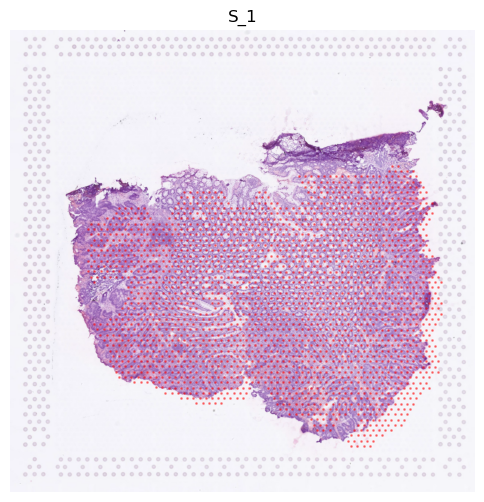

In [12]:
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [13]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,C1,C2,C3,C4,C5,C6,C7,C8,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
0,1554,1297,0.014401,0.057499,0.022033,0.001704,0.533992,1.511707,0.015313,0.020029,...,1.009572e-03,2.068237,0.121361,0.007344,0.000017,0.036891,0.035934,0.118937,0.001472,0.050057
1,462,1502,0.116196,0.197176,0.110600,0.042614,5.587681,0.006885,0.096346,0.001711,...,6.918171e-04,0.014442,0.000238,0.024071,0.000023,0.217589,0.100662,0.004027,0.004122,0.049491
2,1488,1548,0.133284,0.035880,0.061352,0.003073,1.104479,0.009174,0.009175,0.000114,...,9.577447e-05,0.149792,0.001401,0.000699,0.000009,0.024491,0.018810,0.004171,0.000425,0.015348
3,1725,1182,0.087715,0.235223,0.090382,0.013902,8.760482,0.140912,0.188859,0.010154,...,1.964150e-03,0.142549,0.002036,0.047165,0.000022,0.180372,0.202981,0.003709,0.001845,0.116022
4,581,1113,0.128468,0.066399,0.098982,0.047022,3.425771,0.001009,0.026881,0.000468,...,7.189078e-05,0.005920,0.000048,0.006359,0.000585,0.052661,0.032168,0.000107,0.000107,0.013103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,1055,701,0.047236,0.112721,0.052490,0.002092,0.000913,0.393805,0.045220,0.013414,...,7.530558e-03,0.559967,0.154793,0.133587,0.000013,0.051041,0.113100,0.003147,0.004971,0.128265
2193,1225,862,0.070764,0.119310,0.193938,0.001239,0.003851,0.588956,0.037731,0.004072,...,3.219223e-02,0.667076,0.094247,0.136623,0.000009,0.050518,0.119685,0.027743,0.016413,0.287171
2194,765,1479,0.194491,0.048068,0.150061,0.002978,0.119206,0.000213,0.005332,0.000078,...,2.628421e-04,0.000273,0.000022,0.000027,0.000042,0.029386,0.019977,0.000039,0.000119,0.006778
2195,607,1525,0.002968,0.151899,0.015931,0.000071,1.354983,0.000152,0.019254,0.001267,...,1.377452e-03,0.003754,0.001420,0.088000,0.000536,0.073240,0.113631,0.009040,0.000090,0.025716


In [14]:
import h5py
import numpy as np
import pandas as pd

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # 建立存放各 slide spot 表格的字典：train_spot_tables
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # 從 HDF5 讀取資料並轉換成 NumPy array，再轉換成 DataFrame
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        # 加入 slide_name 欄位，用以日後依照 slide 分組儲存
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")


# ------------------------------
# Step 2: 合併所有 slide 資料，並取得 cell type 欄位 (例如：以 "C" 起始)
# ------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

# 檢查是否有 slide_name 欄位，若沒有則加入 (保險起見)
if "slide_name" not in all_train_spots_df.columns:
    # 這裡假設原本每個 df 都有 slide_name，但若不在 union 中，可以根據索引補回
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")
    
# 假設所有 cell type 欄位皆以 "C" 為開頭，例如 "C1", "C2", ..., "C35"
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

print("Cell Type Abundance 的描述統計:")
print(all_train_spots_df[cell_type_cols].describe())

# -----------------------------------------------------
# Step 3: 定義處理函式：對單一 cell type 欄位進行 log2 轉換，然後利用 IQR 找出極端值，
#         並將極端值以該 cell type 在非極端值的中位數（或平均值）來替換。
# -----------------------------------------------------
def log2_transform_and_filter_impute(series, add_constant=1, factor=1.5, use_median=True):
    """
    參數:
      series: 原始數值的 pandas Series (一個 cell type 跨 spots)
      add_constant: 加常數避免 log2(0)（預設 1）
      factor: IQR 法中的放大因子（預設 1.5）
      use_median: 若 True 則以中位數填補極端值，否則以平均值填補

    回傳:
      filtered_series: 經 log2 轉換後，極端值被取代為中位數/平均值的 pandas Series
      stats: (Q1, Q3, lower_bound, upper_bound, imputed_value)
    """
    # 1. Log2 轉換 (加常數避免 0)
    log2_vals = np.log2(series + add_constant)
    
    # 2. 以整個 cell type 資料計算 IQR
    Q1 = log2_vals.quantile(0.25)
    Q3 = log2_vals.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # 3. 非極端值的 mask
    non_outlier_mask = (log2_vals >= lower_bound) & (log2_vals <= upper_bound)
    
    # 4. 以非極端值來計算中位數或平均值的替代值
    if use_median:
        imputed_value = log2_vals[non_outlier_mask].median()
    else:
        imputed_value = log2_vals[non_outlier_mask].mean()
    
    # 5. 將極端值取代成 imputed_value
    filtered_series = log2_vals.copy()
    filtered_series[~non_outlier_mask] = imputed_value
    
    # 印出一些狀態資訊
    print(f"{series.name} - Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}, Lower: {lower_bound:.3f}, Upper: {upper_bound:.3f}")
    print(f"極端值替換成: {imputed_value:.3f} (使用 {'中位數' if use_median else '平均值'})")
    print(f"原始筆數: {len(series)}, 被替換極端值筆數: {np.sum(~non_outlier_mask)}\n")
    
    return filtered_series, (Q1, Q3, lower_bound, upper_bound, imputed_value)


已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6
Cell Type Abundance 的描述統計:
                C1           C2           C3            C4            C5  \
count  8349.000000  8349.000000  8349.000000  8.349000e+03  8.349000e+03   
mean      1.315875     0.127599     0.910304  5.073074e-01  1.057699e+00   
std       2.955853     0.172966     2.055712  1.182995e+00  1.837263e+00   
min       0.000011     0.000261     0.000083  1.634036e-07  9.356235e-07   
25%       0.016408     0.028648     0.020510  3.646352e-04  6.655373e-03   
50%       0.069853     0.070915     0.067104  4.581381e-03  2.888173e-01   
75%       0.812378     0.156029     0.530473  2.719029e-01  1.140192e+00   
max      29.454552     2.314705    16.949463  9.771889e+00  1.588755e+01   

                 C6           C7            C8            C9           C10  \
count  8.349000e+03  8349.000000  8.349000e+03  8.349000e+03  8.349000e+03   
mean   1.669755e-01     0.050874  1.636851

In [15]:
# -----------------------------------------------------
# Step 4: 對所有 cell type 欄位先進行 log2 轉換 & 極端值替換，再將結果進行 Z-score 標準化
# -----------------------------------------------------
# 建立新的 DataFrame 存放處理結果
filtered_df = all_train_spots_df.copy()

# 用來保存各 cell type 標準化統計參數 (mean, std)
zscore_params = {}

# 針對每個 cell type，先 log2 轉換並極端值替換
for col in cell_type_cols:
    # log2 轉換及極端值替換
    filtered_series, stats = log2_transform_and_filter_impute(all_train_spots_df[col],
                                                              add_constant=1,
                                                              factor=1.5,
                                                              use_median=True)
    # 存入新的欄位：例如 "log2_filtered_C1"
    new_col_name = "log2_filtered_" + col
    filtered_df[new_col_name] = filtered_series
    
    # 接下來對 log2_filtered 進行 Z-score 標準化
    mean_val = filtered_series.mean()
    std_val = filtered_series.std()
    zscore_col = (filtered_series - mean_val) / std_val
    
    # 存入新欄位：例如 "zscore_log2_filtered_C1"
    zscore_col_name = "zscore_log2_filtered_" + col
    filtered_df[zscore_col_name] = zscore_col
    
    # 儲存統計參數 (便於未來反轉標準化)
    zscore_params[col] = {"mean": mean_val, "std": std_val}

C1 - Q1: 0.023, Q3: 0.858, IQR: 0.834, Lower: -1.228, Upper: 2.109
極端值替換成: 0.068 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 1064

C2 - Q1: 0.041, Q3: 0.209, IQR: 0.168, Lower: -0.212, Upper: 0.462
極端值替換成: 0.090 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 542

C3 - Q1: 0.029, Q3: 0.614, IQR: 0.585, Lower: -0.848, Upper: 1.491
極端值替換成: 0.066 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 1202

C4 - Q1: 0.001, Q3: 0.347, IQR: 0.346, Lower: -0.519, Upper: 0.867
極端值替換成: 0.003 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 1418

C5 - Q1: 0.010, Q3: 1.098, IQR: 1.088, Lower: -1.623, Upper: 2.730
極端值替換成: 0.317 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 369

C6 - Q1: 0.000, Q3: 0.089, IQR: 0.089, Lower: -0.133, Upper: 0.222
極端值替換成: 0.001 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 1618

C7 - Q1: 0.010, Q3: 0.090, IQR: 0.080, Lower: -0.110, Upper: 0.210
極端值替換成: 0.027 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 696

C8 - Q1: 0.000, Q3: 0.010, IQR: 0.010, Lower: -0.014, Upper: 0.024
極端值替換成: 0.001 (使用 中位數)
原始筆數: 8349, 被替換極端值筆數: 1304

C9 - Q1: 0.000, Q3: 0.254, IQR: 0.254, Lower: -0.381, Upper

In [16]:
# -----------------------------------------------------
# Step 5: 檢查處理後的結果
# -----------------------------------------------------
print("處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):")
zscore_cols = ["zscore_log2_filtered_" + col for col in cell_type_cols]
print(filtered_df[zscore_cols].describe())

# 若需要，你也可以將 zscore_params 存下來，以便後續反轉標準化
print("Z-score 標準化的統計參數 (每個 cell type):")
for col, params in zscore_params.items():
    print(f"{col}: mean = {params['mean']:.3f}, std = {params['std']:.3f}")


處理後 (log2 並極端值替換, 再 Z-score 標準化) 的描述統計 (針對新欄位):
       zscore_log2_filtered_C1  zscore_log2_filtered_C2  \
count             8.349000e+03             8.349000e+03   
mean              2.553154e-17            -4.042494e-17   
std               1.000000e+00             1.000000e+00   
min              -5.949500e-01            -1.157524e+00   
25%              -5.442922e-01            -7.708987e-01   
50%              -4.486263e-01            -2.998154e-01   
75%              -7.590045e-02             4.752220e-01   
max               3.958342e+00             3.260391e+00   

       zscore_log2_filtered_C3  zscore_log2_filtered_C4  \
count             8.349000e+03             8.349000e+03   
mean              1.293598e-16             1.106367e-17   
std               1.000000e+00             1.000000e+00   
min              -6.230925e-01            -4.100220e-01   
25%              -5.286331e-01            -4.069247e-01   
50%              -4.084771e-01            -3.938079e-01   
75%    

In [17]:
for col, params in zscore_params.items():
    print(f"{col}: mean = {params['mean']:.3f}, std = {params['std']:.3f}")

C1: mean = 0.276, std = 0.463
C2: mean = 0.121, std = 0.104
C3: mean = 0.193, std = 0.309
C4: mean = 0.070, std = 0.170
C5: mean = 0.588, std = 0.701
C6: mean = 0.015, std = 0.037
C7: mean = 0.045, std = 0.048
C8: mean = 0.003, std = 0.005
C9: mean = 0.055, std = 0.121
C10: mean = 0.004, std = 0.010
C11: mean = 0.003, std = 0.007
C12: mean = 0.018, std = 0.022
C13: mean = 0.002, std = 0.004
C14: mean = 0.020, std = 0.029
C15: mean = 0.039, std = 0.063
C16: mean = 0.374, std = 0.505
C17: mean = 0.077, std = 0.112
C18: mean = 0.050, std = 0.060
C19: mean = 0.023, std = 0.038
C20: mean = 0.053, std = 0.059
C21: mean = 0.015, std = 0.027
C22: mean = 0.009, std = 0.017
C23: mean = 0.110, std = 0.104
C24: mean = 0.110, std = 0.163
C25: mean = 0.016, std = 0.032
C26: mean = 0.004, std = 0.008
C27: mean = 0.025, std = 0.062
C28: mean = 0.004, std = 0.008
C29: mean = 0.010, std = 0.018
C30: mean = 0.001, std = 0.003
C31: mean = 0.097, std = 0.094
C32: mean = 0.083, std = 0.081
C33: mean = 0.005

In [18]:
# ------------------------------
# Step 5: 根據原始的 slide_name 分組，並把處理後的結果存成 HDF5 檔案
#         格式與輸入時相同，並儲存 zscore_params 資訊
# ------------------------------
# 確保 filtered_df 中有 "slide_name" 欄位
if "slide_name" not in filtered_df.columns:
    filtered_df["slide_name"] = all_train_spots_df["slide_name"]

# 定義輸出檔案路徑 (請自行修改)
output_file = "processed_train_spots.h5"

with h5py.File(output_file, "w") as f_out:
    # 建立用於存放各 slide 資料的 group
    slides_group = f_out.create_group("spots/Train")
    
    # 依據 slide_name 分組
    for slide_name, group_df in filtered_df.groupby("slide_name"):
        # 這裡依照原始資料格式，儲存處理後的 zscore 欄位
        slide_data = group_df[[ "zscore_log2_filtered_" + col for col in cell_type_cols ]].to_records(index=False)
        slides_group.create_dataset(slide_name, data=slide_data)
    
    # 另外建立一個 group 儲存 zscore_params
    params_grp = f_out.create_group("zscore_params")
    for col, params in zscore_params.items():
        # 儲存 [mean, std] 作為 numpy array
        params_grp.create_dataset(col, data=np.array([params["mean"], params["std"]]))
        
print(f"處理後的資料和 zscore_params 已儲存到 {output_file}")

處理後的資料和 zscore_params 已儲存到 processed_train_spots.h5


In [34]:
import json
# -----------------------------------------------------
# Step 6: 儲存處理結果與統計參數到檔案
# -----------------------------------------------------
# 儲存處理後的 DataFrame 為 CSV 檔
filtered_df.to_csv("zscore_standardized_results.csv", index=False)
print("\n儲存處理後的結果到 'zscore_standardized_results.csv'")

# 儲存 zscore_params 字典為 JSON 檔 (便於後續還原標準化)
with open("zscore_params.json", "w") as f:
    json.dump(zscore_params, f, indent=4)
print("儲存 Z-score 標準化統計參數到 'zscore_params.json'")


儲存處理後的結果到 'zscore_standardized_results.csv'
儲存 Z-score 標準化統計參數到 'zscore_params.json'


## see plots

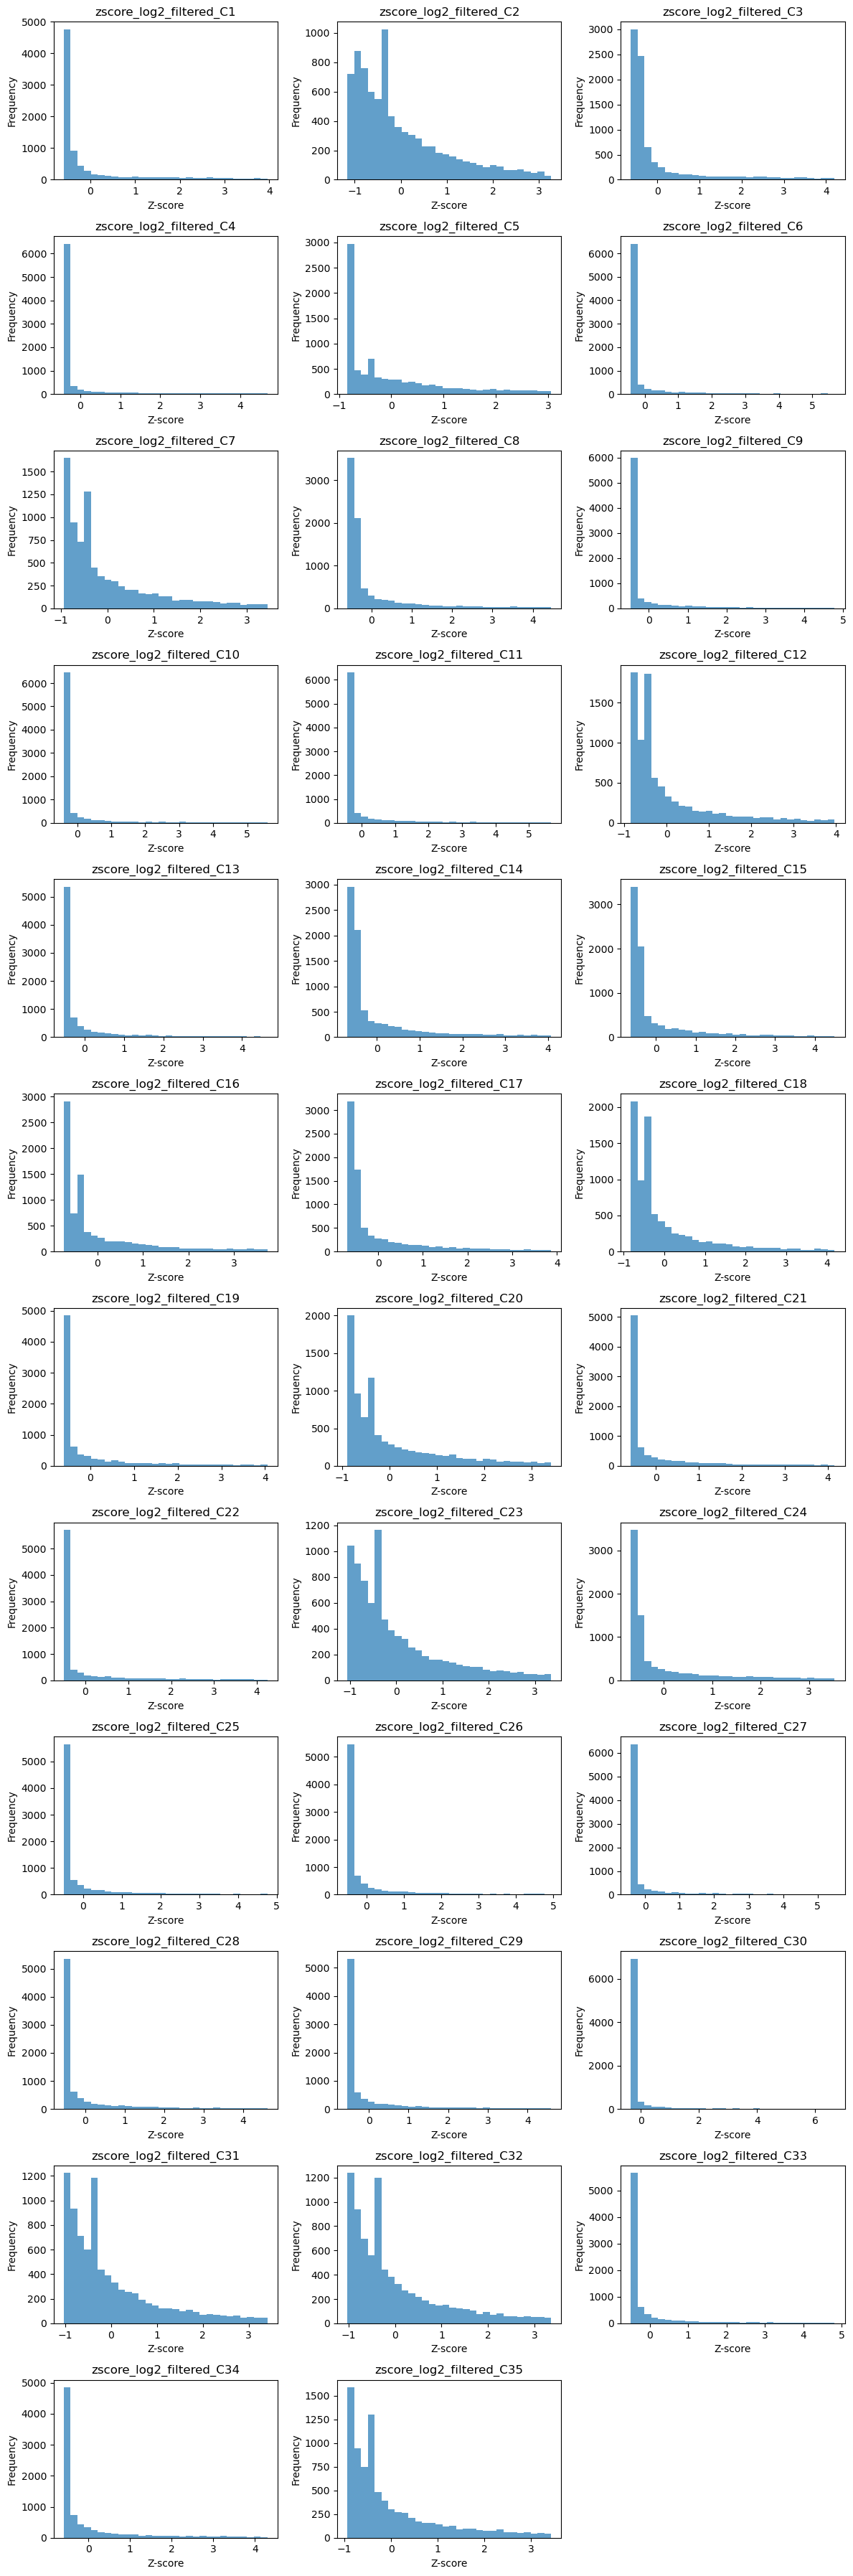

In [31]:
import matplotlib.pyplot as plt

# 取得所有經過 Z-score 標準化後的欄位名稱
zscore_cols = ["zscore_log2_filtered_" + col for col in cell_type_cols]

# 設定圖表排版: 例如每排顯示 3 個子圖
ncols = 3
nrows = (len(zscore_cols) // ncols) + (1 if len(zscore_cols) % ncols else 0)

# 建立圖表與子圖，設定圖表大小
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()  # 攤平成一維陣列，方便用迴圈操作

for i, col in enumerate(zscore_cols):
    ax = axes[i]
    # 取出每個 cell type 經標準化後的數據
    data = filtered_df[col]
    
    # 畫 histogram，bin 數根據資料分布可做調整 (這裡預設 30 個 bin)
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Z-score")
    ax.set_ylabel("Frequency")
    
# 如果有多餘的子圖，將其移除
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
    
fig.tight_layout()
plt.show()


## Try log2, Box-Cox 與 Yeo-Johnson  show image

已讀取 slide: S_1
已讀取 slide: S_2
已讀取 slide: S_3
已讀取 slide: S_4
已讀取 slide: S_5
已讀取 slide: S_6
Cell Type Abundance 的描述統計:
                C1           C2           C3            C4            C5  \
count  8349.000000  8349.000000  8349.000000  8.349000e+03  8.349000e+03   
mean      1.315875     0.127599     0.910304  5.073074e-01  1.057699e+00   
std       2.955853     0.172966     2.055712  1.182995e+00  1.837263e+00   
min       0.000011     0.000261     0.000083  1.634036e-07  9.356235e-07   
25%       0.016408     0.028648     0.020510  3.646352e-04  6.655373e-03   
50%       0.069853     0.070915     0.067104  4.581381e-03  2.888173e-01   
75%       0.812378     0.156029     0.530473  2.719029e-01  1.140192e+00   
max      29.454552     2.314705    16.949463  9.771889e+00  1.588755e+01   

                 C6           C7            C8            C9           C10  \
count  8.349000e+03  8349.000000  8.349000e+03  8.349000e+03  8.349000e+03   
mean   1.669755e-01     0.050874  1.636851

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74641/2734470026.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_train_spots_df[new_col_yeo] = yeojohnson_vals
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74641/2734470026.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_train_spots_df[new_col_log2] = log2_vals
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_74641/2734470026.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

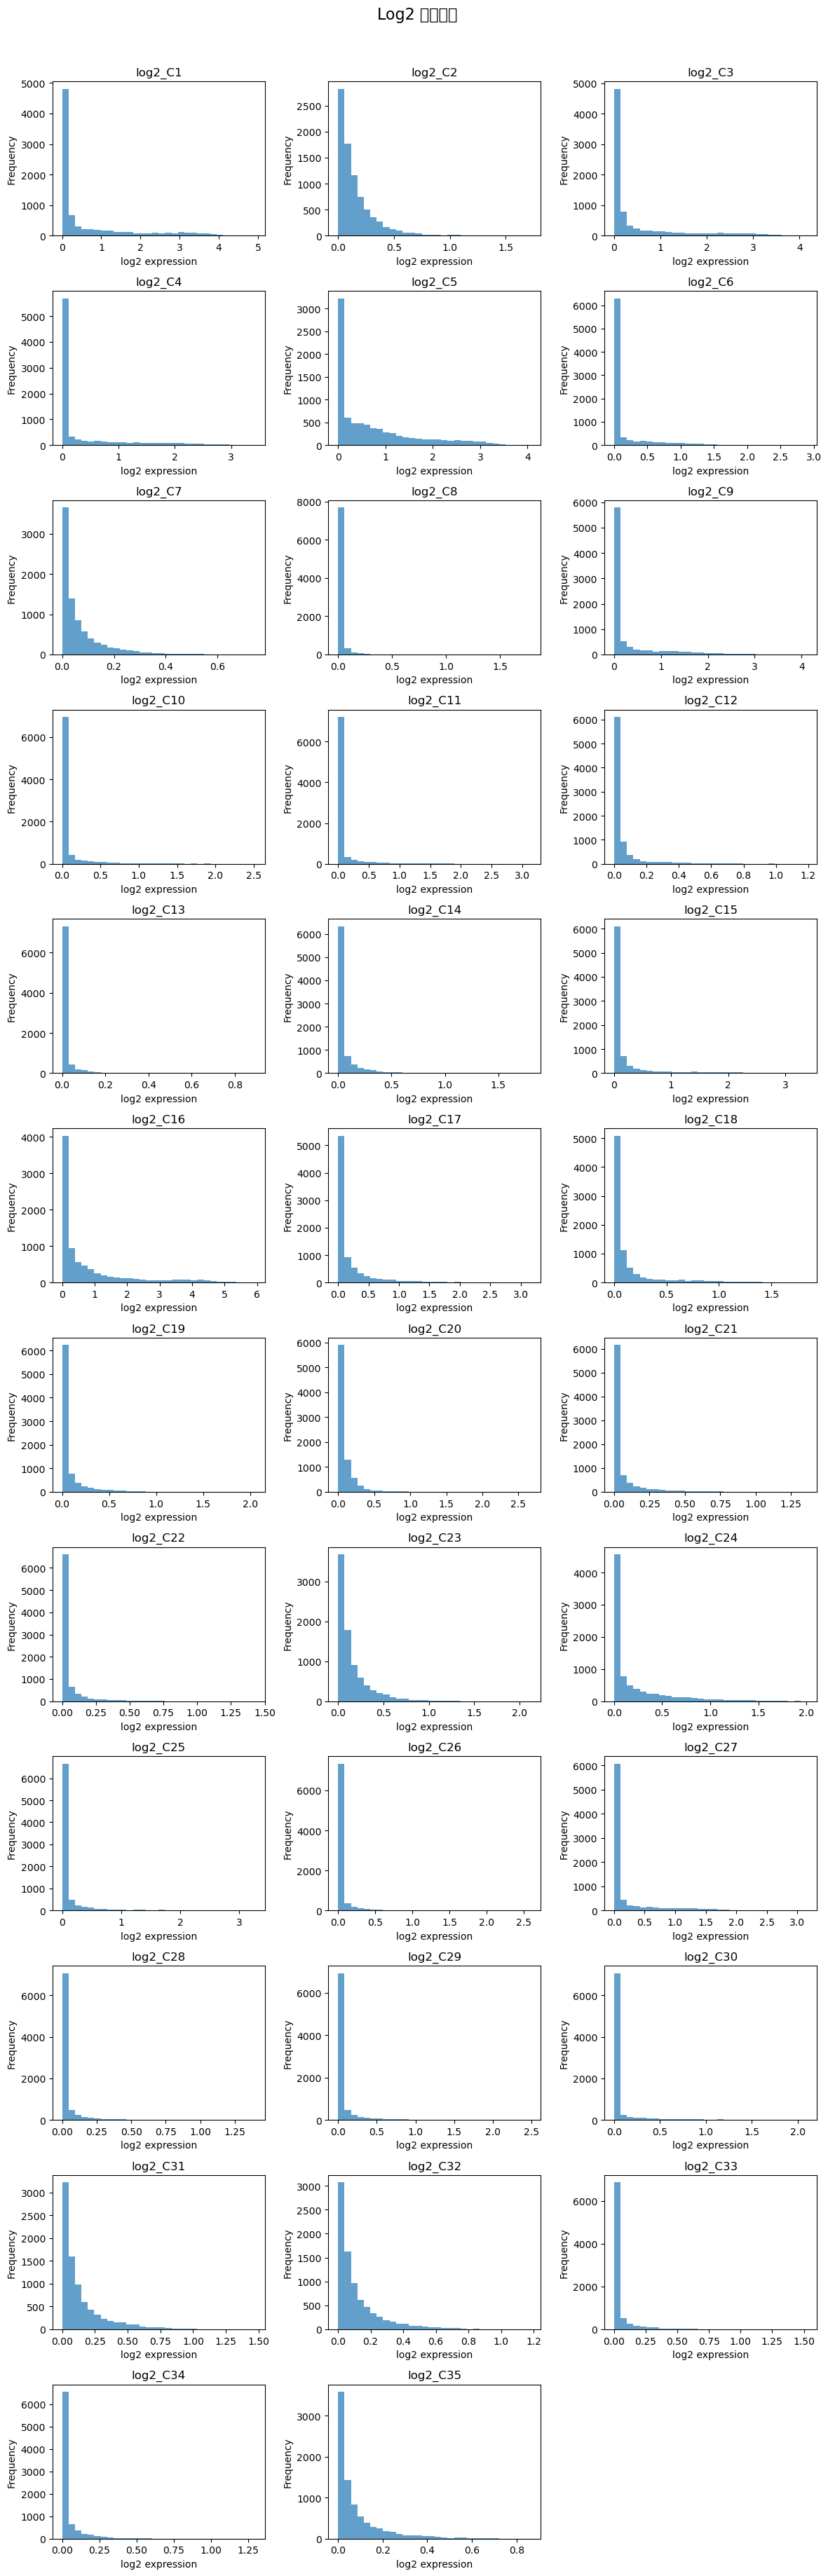

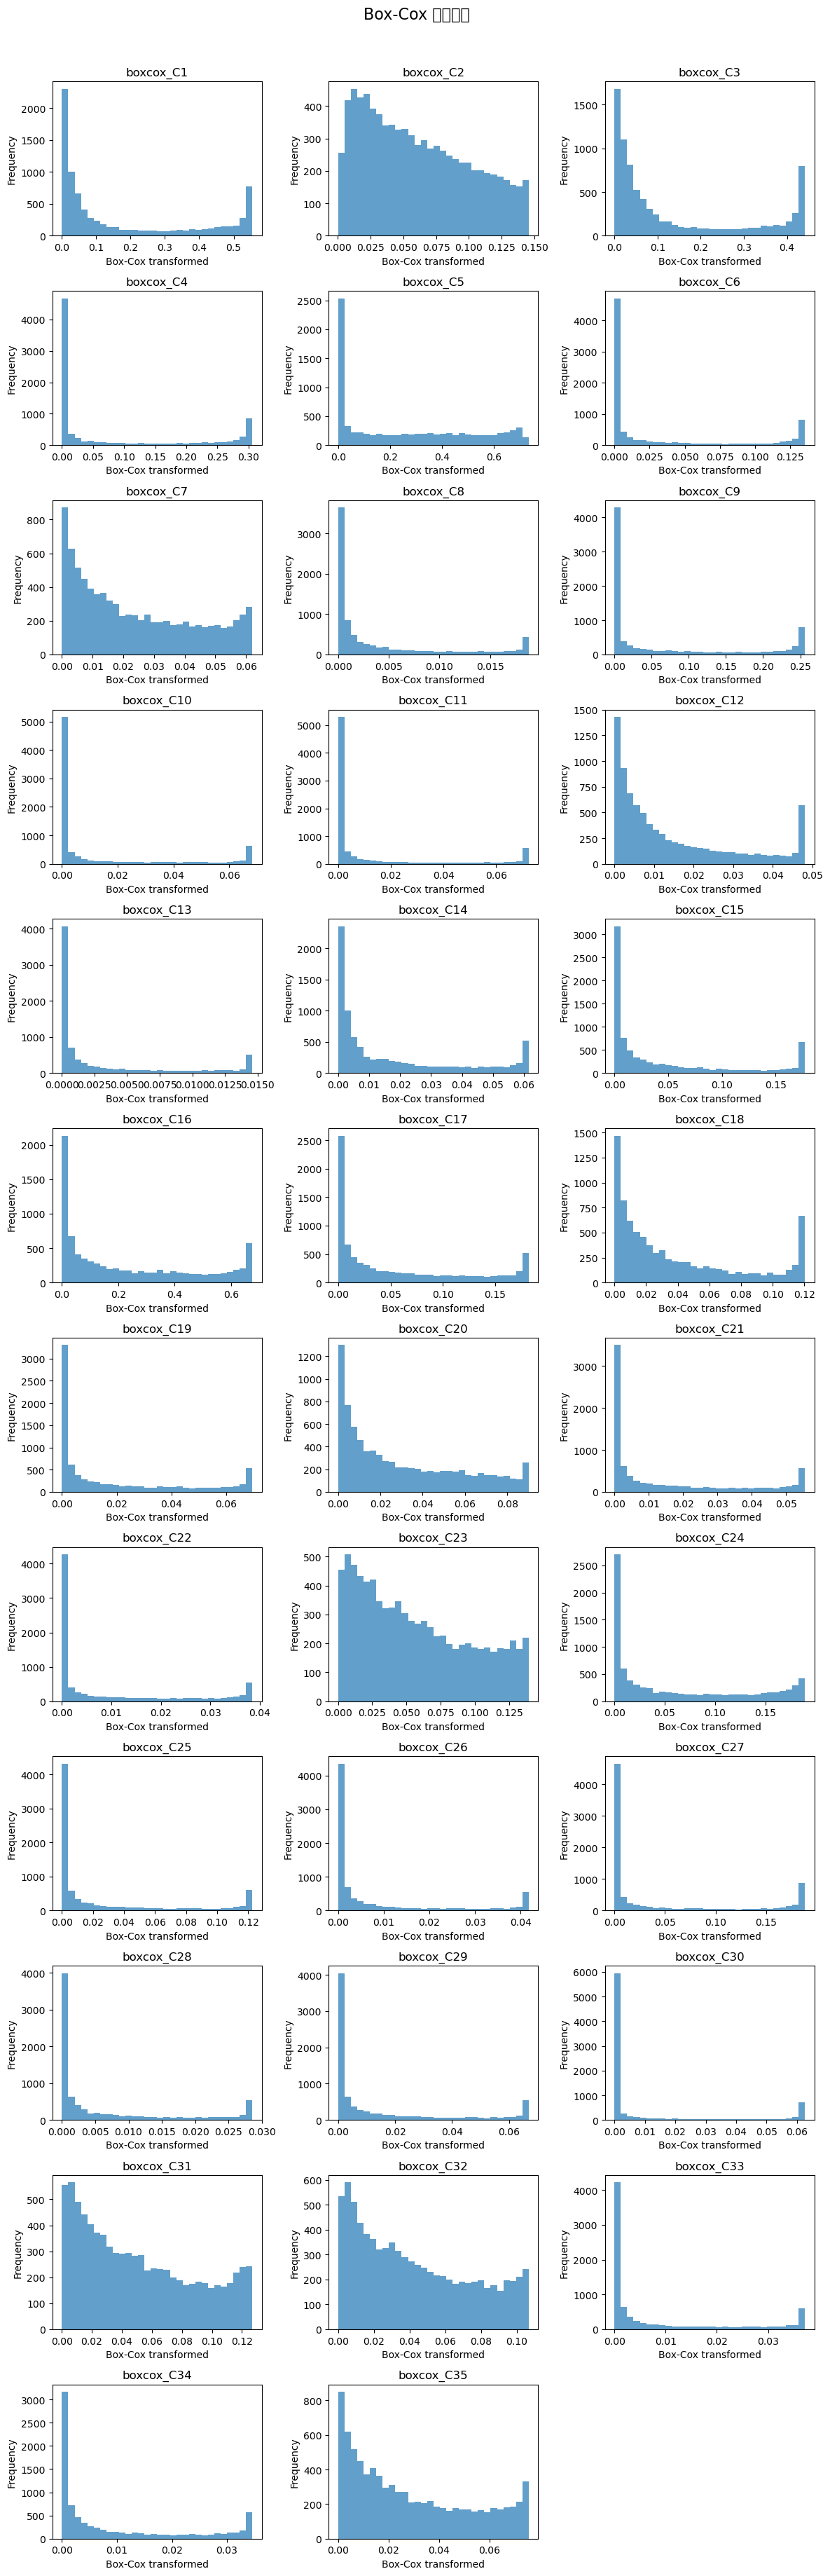

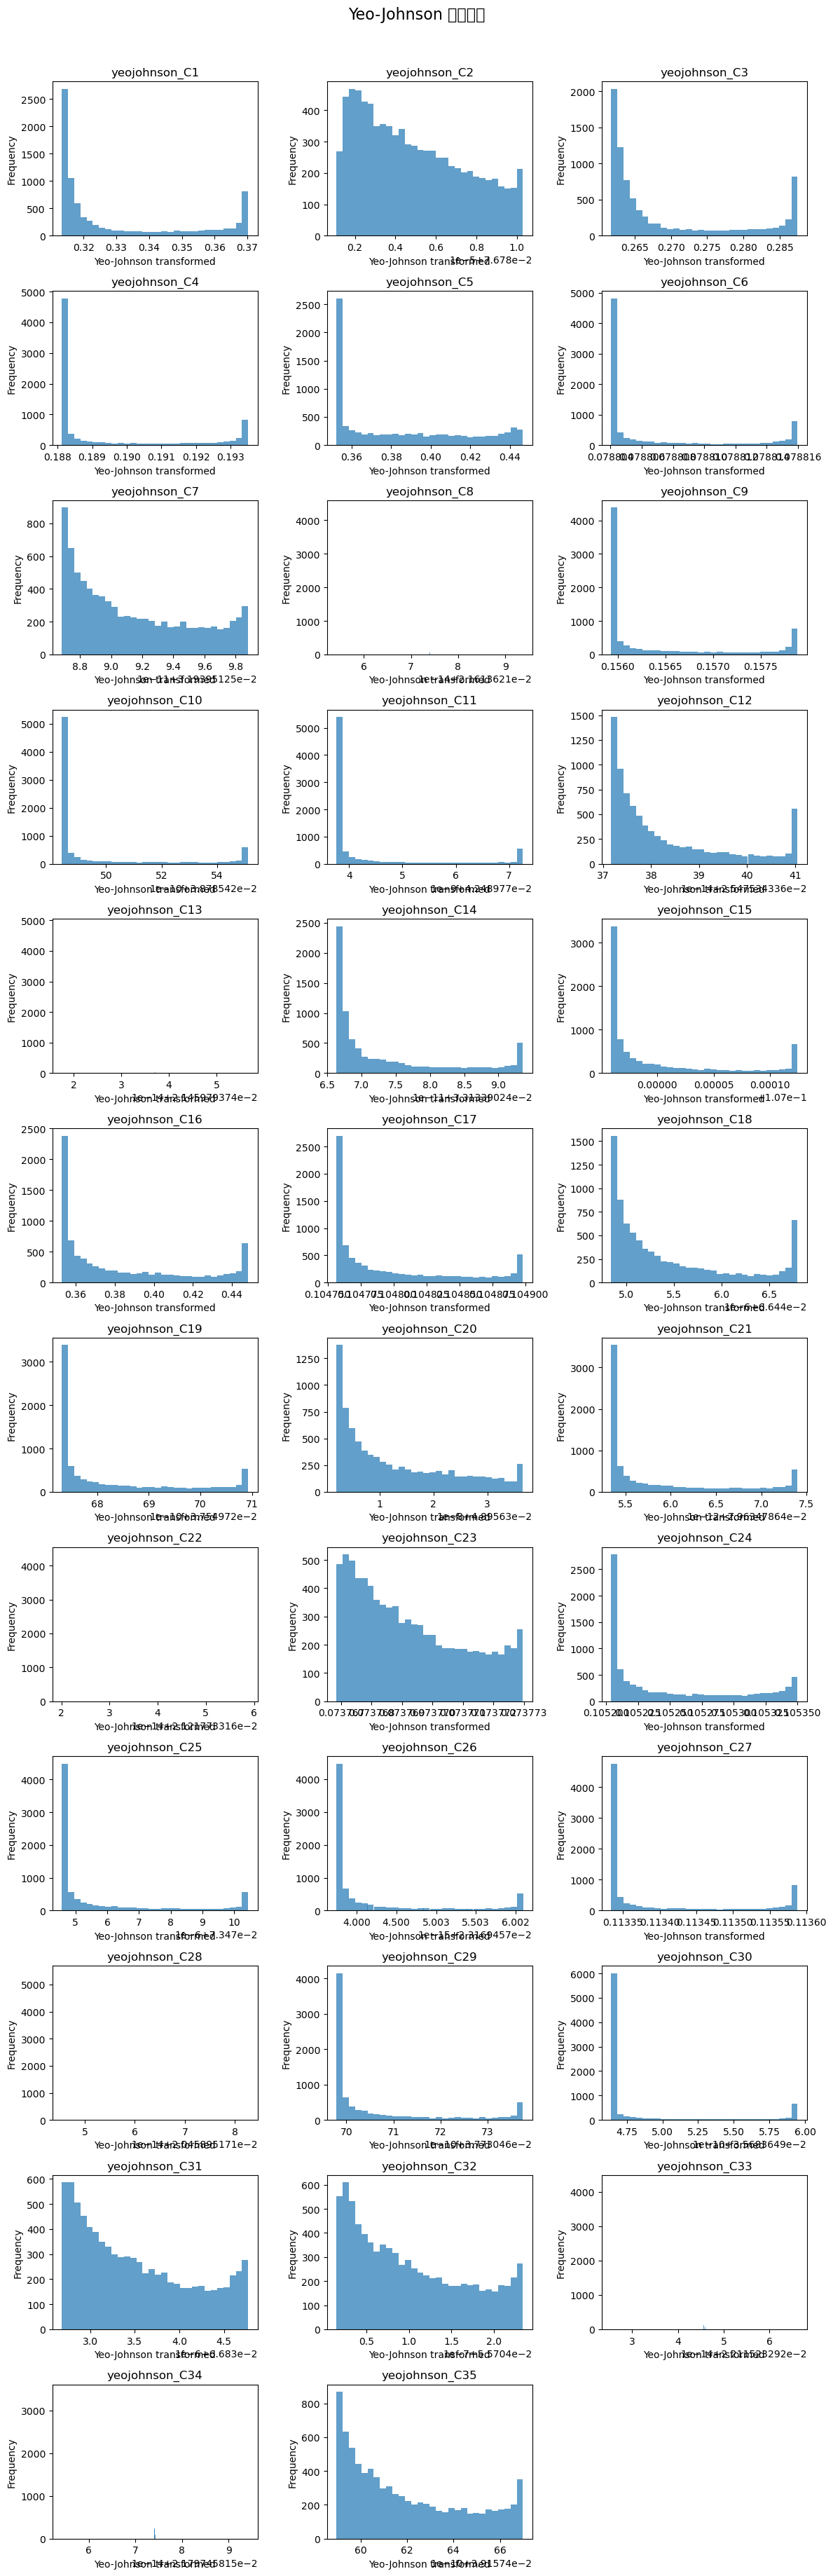

In [32]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import boxcox, yeojohnson

# ---------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，建立 DataFrame 字典
# ---------------------------
with h5py.File("../elucidata_ai_challenge_data.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # 存放各 slide spot 資料的字典
    train_spot_tables = {}
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        train_spot_tables[slide_name] = df
        print(f"已讀取 slide: {slide_name}")

# ---------------------------
# Step 2: 合併所有 slide 資料並挑選 cell type 欄位（假設名稱以 "C" 開頭）
# ---------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("C")]

print("Cell Type Abundance 的描述統計:")
print(all_train_spots_df[cell_type_cols].describe())

# ---------------------------
# Step 3: 對每個 cell type 欄位進行三種轉換：log2、Box-Cox 與 Yeo-Johnson
# ---------------------------
# 加常數用以避免 log2 與 Box-Cox 出現 0 值問題
add_constant = 1

# 用來存放新產生的欄位名稱，以便後續繪圖
log2_cols = []
boxcox_cols = []
yeojohnson_cols = []

for col in cell_type_cols:
    # 原始數值加常數
    data = all_train_spots_df[col] + add_constant
    
    # log2 轉換： np.log2(data)
    log2_vals = np.log2(data)
    
    # Box-Cox 轉換：注意會同時返回轉換後的數值與 lambda 值
    try:
        boxcox_vals, lambda_boxcox = boxcox(data)
    except Exception as e:
        print(f"Box-Cox 轉換失敗 {col}: ", e)
        boxcox_vals = np.full_like(data, np.nan)
    
    # Yeo-Johnson 轉換：同時返回轉換後數值與 lambda 值
    yeojohnson_vals, lambda_yeojohnson = yeojohnson(data)
    
    # 新欄位名稱
    new_col_log2 = "log2_" + col
    new_col_boxcox = "boxcox_" + col
    new_col_yeo = "yeojohnson_" + col
    
    # 加入新欄位到 DataFrame
    all_train_spots_df[new_col_log2] = log2_vals
    all_train_spots_df[new_col_boxcox] = boxcox_vals
    all_train_spots_df[new_col_yeo] = yeojohnson_vals
    
    # 記錄欄位名稱
    log2_cols.append(new_col_log2)
    boxcox_cols.append(new_col_boxcox)
    yeojohnson_cols.append(new_col_yeo)

# ---------------------------
# Step 4: 分別繪製三種轉換的直方圖以做比較
# ---------------------------

# (1) log2 轉換結果直方圖
ncols = 3
nrows = (len(log2_cols) // ncols) + (1 if len(log2_cols) % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()
for i, col in enumerate(log2_cols):
    ax = axes[i]
    data = all_train_spots_df[col]
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("log2 expression")
    ax.set_ylabel("Frequency")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()
plt.suptitle("Log2 轉換結果", fontsize=16, y=1.02)
plt.show()

# (2) Box-Cox 轉換結果直方圖
ncols = 3
nrows = (len(boxcox_cols) // ncols) + (1 if len(boxcox_cols) % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()
for i, col in enumerate(boxcox_cols):
    ax = axes[i]
    data = all_train_spots_df[col]
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Box-Cox transformed")
    ax.set_ylabel("Frequency")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()
plt.suptitle("Box-Cox 轉換結果", fontsize=16, y=1.02)
plt.show()

# (3) Yeo-Johnson 轉換結果直方圖
ncols = 3
nrows = (len(yeojohnson_cols) // ncols) + (1 if len(yeojohnson_cols) % ncols else 0)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 3))
axes = axes.flatten()
for i, col in enumerate(yeojohnson_cols):
    ax = axes[i]
    data = all_train_spots_df[col]
    ax.hist(data, bins=30, alpha=0.7)
    ax.set_title(col)
    ax.set_xlabel("Yeo-Johnson transformed")
    ax.set_ylabel("Frequency")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
fig.tight_layout()
plt.suptitle("Yeo-Johnson 轉換結果", fontsize=16, y=1.02)
plt.show()
